In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

In [35]:
# clean speech
cl, fs = wavread("sound/speech/sp02.wav")
σ² = 0.0001
# white noise
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn
wavwrite(ns, "sound/mixed/white_speech.wav")
ns, fs = wavread("sound/mixed/bar_speech.wav")

([-0.0016479995117038484; -0.00521866512039552; … ; -0.006317331461531419; -0.0024414807580797754], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x4e, 0x41, 0x4d, 0x08, 0x00  …  0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a, 0x00, 0x00]), WAVChunk(Symbol("id3 "), UInt8[0x49, 0x44, 0x33, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26  …  0x49, 0x6e, 0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a])])

In [36]:
include("helpers/aida_segmentation.jl")
cl_seg = get_frames(cl, fs)
ns_seg = get_frames(ns, fs)
totseg = size(ns_seg, 1)

352

In [37]:
function ar_ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ar_ssm (generic function with 1 method)

In [38]:
@model function lar_model(n, order, artype, c)

    x = randomvar(n)
    y = datavar(Float64, n)

    γ ~ GammaShapeRate(0.00001, 1.0) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(randn(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}
    x0 ~ MvNormalMeanPrecision(100.0 * ones(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}
    τ ~ GammaShapeRate(1.0, 1.0) where {q=MeanField()}

    x_prev = x0

    ct  = constvar(c)

    ar_nodes = Vector{FactorNode}(undef, n)

    for i in 1:n
        ar_nodes[i], x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order, ARsafe()) }

        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), τ) where {q=MeanField()}

        x_prev = x[i]
    end

    return x, y, θ, γ, τ, ar_nodes
end

lar_model (generic function with 1 method)

In [39]:
function inference_lar(data, order, niter)
    n = length(data)
    artype = Multivariate
    c = zeros(order); c[1] = 1.0
    model, (x, y, θ, γ, τ, ar_nodes) = lar_model(n, order, artype, c)

    γ_buffer = nothing
    τ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    τsub = subscribe!(getmarginal(τ), (mτ) -> τ_buffer = mτ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(τ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)))

    for i in 1:n
        setmarginal!(ar_nodes[i], :y_x, MvNormalMeanPrecision(100.0 * ones(2*order), Matrix{Float64}(I, 2*order, 2*order)))
    end

    for i in 1:niter
        update!(y, data)
    end

    unsubscribe!(γsub)
    unsubscribe!(τsub)
    unsubscribe!(θsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)

    return γ_buffer, τ_buffer, θ_buffer, x_buffer, fe
end

inference_lar (generic function with 1 method)

In [40]:
@model function gaussian_model(n)

    y = datavar(Float64, n)

    γ ~ GammaShapeRate(1.0, 1.0) where {q=MeanField()}
    x_0 ~ NormalMeanPrecision(0.0, 1.0) where {q=MeanField()}
    x ~ NormalMeanPrecision(x_0, γ) where {q=MeanField()}

    for i in 1:n
        y[i] ~ NormalMeanPrecision(x, 1e4) where {q=MeanField()}
    end

    return y, x, γ
end

gaussian_model (generic function with 1 method)

In [41]:
function inference_gaussian(outputs, niter)
    n = length(outputs)
    model, (y, x, γ) = gaussian_model(n, options = (limit_stack_depth = 500, ))
    γ_buffer = nothing
    x_buffer = nothing
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (my) -> γ_buffer = my)
    xsub = subscribe!(getmarginal(x), (mx) -> x_buffer = mx)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(x, NormalMeanPrecision(0.0, 1.0))

    for i in 1:niter
        update!(y, outputs)
    end

    unsubscribe!(γsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)

    return x_buffer, γ_buffer, fe
end

inference_gaussian (generic function with 1 method)

In [42]:
ar_order = 10
vmp_iter = 50
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [43]:
ProgressMeter.@showprogress for segnum in 1:totseg
    inputs, outputs = ar_ssm(ns_seg[segnum, :], ar_order)
    γ, τ, θ, x, fe = inference_lar(outputs, ar_order, vmp_iter)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_ar[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(outputs, vmp_iter)
    mx, vx = mean(x), cov(x)
    mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:35


In [44]:
vad = [x[end] < y[end] for (x, y) in zip(eachrow(fe_ar), eachrow(fe_gaussian))]

352-element Vector{Bool}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [45]:
findall(isequal(1), vad)

17-element Vector{Int64}:
 127
 128
 129
 133
 134
 135
 136
 137
 138
 139
 140
 141
 142
 144
 190
 191
 192

In [48]:
fe_gaussian[127, :]

50-element Vector{Float64}:
 131.07978570451525
 131.07216933719502
 131.07208444528993
 131.07208357053975
 131.07208356160362
 131.07208356151244
 131.07208356151148
 131.07208356151142
 131.07208356151148
 131.07208356151148
 131.07208356151142
 131.07208356151148
 131.07208356151142
   ⋮
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148
 131.07208356151148

In [49]:
fe_ar[127, :]

50-element Vector{Float64}:
 2463.730794061039
  315.5432121551015
  313.8005133929006
  312.1478445483694
  310.3915571765719
  308.502765690101
  306.4978331636395
  304.3232257420268
  301.94733145729697
  299.3605416973014
  296.51800152815434
  293.377327336777
  289.880858656985
    ⋮
   99.63464380767346
   99.63455575685566
   99.63490324710438
   99.63512201434605
   99.63506393553189
   99.6351114632771
   99.63518653532628
   99.63524555178265
   99.63531363991842
   99.63530373260755
   99.63539941685985
   99.63525199769037

In [51]:
rseg = 192

192

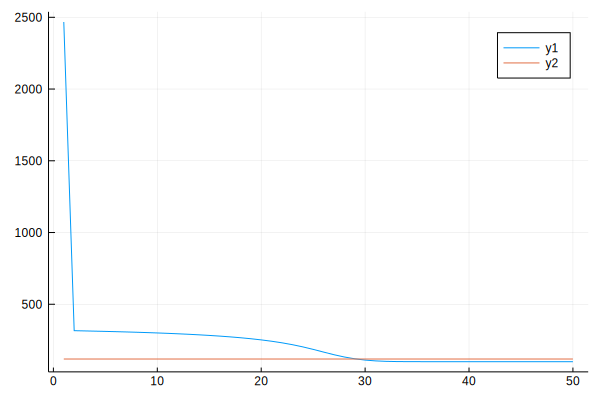

In [52]:
plot(fe_ar[rseg, :])
plot!(fe_gaussian[rseg, :])

In [53]:
println("$(fe_gaussian[rseg, :][end]), $(fe_ar[rseg, :][end])")

118.34092346667836, 99.77890188351694


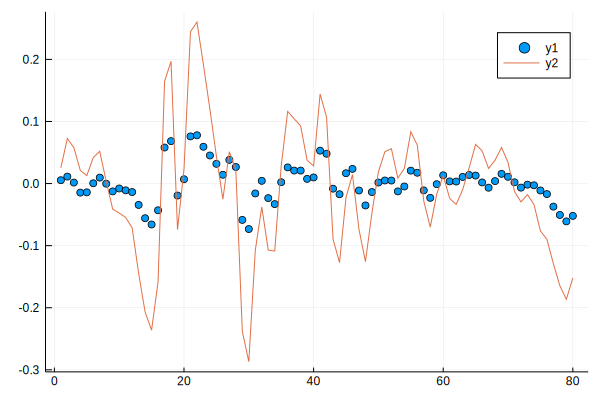

In [54]:
scatter(ns_seg[rseg, :])
plot!(cl_seg[rseg, :])